In [1]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random

In [2]:
mat_list = [Path(f).stem for f in glob.glob("./Data/AFLW2000/*.mat")]

In [3]:
len(mat_list)

2000

In [4]:
mat = sio.loadmat('./Data/AFLW2000/'+mat_list[0])
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68'])

In [5]:
#x,y,z
mat['pt3d_68'][:2]

array([[ 93.29257 , 102.73456 , 112.895584, 123.28525 , 139.78192 ,
        164.46127 , 191.33969 , 221.17944 , 245.2015  , 250.50003 ,
        241.3157  , 228.69785 , 216.26443 , 206.66058 , 200.35663 ,
        195.79971 , 189.77711 , 162.1892  , 177.12144 , 191.10753 ,
        202.79074 , 211.57553 , 235.21884 , 238.80682 , 240.50757 ,
        240.12512 , 235.60696 , 231.40273 , 242.55536 , 255.27722 ,
        260.63315 , 232.64783 , 241.0774  , 246.9613  , 248.19513 ,
        246.62677 , 181.4766  , 192.31177 , 197.72284 , 201.64615 ,
        200.28427 , 192.42871 , 227.5274  , 234.00642 , 240.56168 ,
        238.09756 , 240.3786  , 235.89331 , 222.18256 , 237.98291 ,
        247.87128 , 251.17851 , 253.00726 , 252.54663 , 246.42764 ,
        252.4335  , 255.13101 , 253.12787 , 248.6387  , 240.34372 ,
        225.1156  , 244.15706 , 248.72223 , 250.16667 , 245.56621 ,
        249.37953 , 247.7493  , 243.62155 ],
       [262.63806 , 285.60086 , 307.05472 , 325.9063  , 345.35004 ,
   

In [6]:
# Get 2D landmarks
pt2d = mat['pt2d']
pt2d.shape

(2, 21)

In [7]:
# Get [pitch, yaw, roll]
mat['Pose_Para'][0][:3]

array([ 0.51097006, -0.974573  , -0.36945397], dtype=float32)

In [8]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

def get_pt3d_68_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt3d_68 = mat['pt3d_68']
    return pt3d_68[:2]

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params


class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):

        # img : displays the img by converting it to RGB
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        
        # mat_path: get the .mat path for each img ex: './Data/AFLW2000/image00002.mat'
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)
        #-------------------------------------------------------------
        # Crop the face loosely
        pt3d_68 = get_pt3d_68_from_mat(mat_path)
        pt3d_68 = pt3d_68.ravel()
        pt3d_68_features = pt3d_68
    
        
        '''x_min = min(pt3d_68[0,:])
        y_min = min(pt3d_68[1,:])
        x_max = max(pt3d_68[0,:])
        y_max = max(pt3d_68[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))'''
        # --------------------------------------------------------------
        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]
        
        
        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index], pt3d_68_features

    def __len__(self):
        # 2,000
        return self.length

In [9]:
demo=AFLW2000("./Data/AFLW2000/*.mat",'./Data/AFLW2000/')

In [10]:
demo[0]

(<PIL.Image.Image image mode=RGB size=450x450 at 0x7F58A0DBF640>,
 array([33, 25, 34]),
 [1.044306042017331, -22.874238643575588, 4.908885557905314],
 'image00002',
 array([121.868034, 122.36761 , 126.81924 , 130.83179 , 137.52313 ,
        148.52173 , 161.52802 , 182.87668 , 213.94006 , 248.00537 ,
        274.67615 , 293.22473 , 309.20724 , 321.27457 , 329.8783  ,
        339.07126 , 345.24066 , 144.61288 , 158.1359  , 175.37297 ,
        191.31126 , 205.48387 , 261.70496 , 277.2635  , 294.11136 ,
        311.59164 , 323.95364 , 231.0957  , 229.7904  , 227.30476 ,
        225.08842 , 202.42142 , 210.7933  , 222.43806 , 235.00792 ,
        244.54094 , 162.57912 , 173.47615 , 188.50098 , 201.39299 ,
        188.09201 , 172.65819 , 260.8649  , 275.8604  , 291.34073 ,
        301.85168 , 289.989   , 273.8536  , 180.50743 , 192.32265 ,
        209.19904 , 218.46085 , 228.46553 , 248.99286 , 261.81235 ,
        243.97612 , 228.25139 , 212.72568 , 199.55211 , 189.6707  ,
        183.1438  ,

In [11]:
features=[]
labels=[]
imgs=[]
xy = []
for i in range(2000):
    pla=demo.__getitem__(i)
    features.append(pla[1])
    x = np.array(pla[2], dtype=np.float32)
    labels.append(x)
    imgs.append(pla[3])
    xy.append(pla[4])

In [12]:
labels

[array([  1.044306 , -22.874239 ,   4.9088855], dtype=float32),
 array([68.15524 , 26.932743, 17.24367 ], dtype=float32),
 array([ 50.485413, -10.579652, -13.570645], dtype=float32),
 array([ 17.143373, -10.048455, -21.392782], dtype=float32),
 array([ 68.64055 , -50.544582, -59.207973], dtype=float32),
 array([  0.68556523,  -1.5361992 , -12.643008  ], dtype=float32),
 array([ 6.344487 ,  3.2726903, -2.4799209], dtype=float32),
 array([ 1.2876399 , 12.7900505 , -0.39012492], dtype=float32),
 array([ 21.995798,  -9.785002, -25.029804], dtype=float32),
 array([-1.3954765, -1.5428697, -3.2578287], dtype=float32),
 array([71.62279 , 13.547766,  9.571312], dtype=float32),
 array([ 19.67921 ,  -9.058602, -21.860031], dtype=float32),
 array([25.3357    ,  1.8395176 ,  0.22292253], dtype=float32),
 array([ 4.059742  , -6.4751267 ,  0.37222844], dtype=float32),
 array([-102.959045, -300.00034 ,  297.59592 ], dtype=float32),
 array([-28.235657, -25.858303,  28.968445], dtype=float32),
 array([ 

In [13]:
#data1 = np.array(features, dtype=np.float32)
data = np.array(xy, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)
data1=np.concatenate((data,labels),axis=1)

In [14]:
data1.shape

(2000, 139)

In [15]:
Xs = ["x" + str(i) for i in range(68)]
Ys = ["y" + str(i) for i in range(68)]
columns = np.array([Xs,Ys])
columns = list(columns.ravel())
columns.extend(['yaw', 'pitch', 'roll'])
len(columns)

139

In [16]:
df = pd.DataFrame(data1,columns=columns) #convert to a dataframe
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y61,y62,y63,y64,y65,y66,y67,yaw,pitch,roll
0,121.868034,122.367607,126.819237,130.831787,137.523132,148.521729,161.528015,182.876678,213.940063,248.005371,...,310.149048,313.233856,315.107117,322.384613,330.965576,330.701965,324.903870,1.044306,-22.874239,4.908885
1,281.238159,277.339417,274.876953,269.523773,257.788269,240.968155,221.801483,205.846298,207.085449,226.185638,...,303.093811,300.724457,300.060974,303.260895,299.485168,300.598602,302.286499,68.155243,26.932743,17.243670
2,236.385101,239.198257,242.566376,243.971375,242.828186,238.567902,232.561859,229.155289,238.303162,259.122467,...,303.122009,302.877289,302.146454,300.489380,303.481873,304.681732,304.631042,50.485413,-10.579652,-13.570645
3,168.029221,177.697510,190.641602,201.395294,211.957214,222.723099,231.350220,244.332855,268.327637,291.832214,...,315.469391,312.701294,310.133301,300.041290,315.544800,319.498596,320.843994,17.143373,-10.048455,-21.392782
4,280.462250,287.249817,293.892456,297.539368,295.677002,287.270355,271.661591,254.701157,250.219299,261.212463,...,306.811768,307.014893,305.351318,309.934814,311.558899,312.920746,312.058350,68.640549,-50.544582,-59.207973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,112.578934,113.787857,119.259262,125.335999,133.637939,146.153839,162.205170,183.907257,213.987427,243.809875,...,317.068970,317.718140,319.277924,321.063141,324.635498,324.518494,322.085815,-4.035367,-11.293093,6.022806
1996,111.117966,113.647079,115.328712,120.565918,134.109467,158.448425,187.568314,212.202332,223.977646,218.683380,...,316.934998,316.013428,315.392395,316.949585,316.981415,317.922302,318.168457,-81.288437,-13.327947,10.081747
1997,308.227417,309.905334,311.432251,310.488586,303.662415,288.275238,268.575409,248.855255,239.939240,248.186981,...,311.084686,311.580597,311.960449,316.873444,314.677002,315.051239,313.333374,82.005562,-82.961685,-86.483292
1998,106.611572,106.089981,107.328842,109.023941,116.216049,136.338547,162.523712,190.193268,208.983047,210.192596,...,309.402283,310.208862,310.287506,312.933044,313.265747,313.581848,312.269653,-68.249336,-24.090857,25.869925


In [17]:
df.to_csv("data",index=False) #save to file

#Then, to reload:
df = pd.read_csv("data")
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y61,y62,y63,y64,y65,y66,y67,yaw,pitch,roll
0,121.868034,122.36761,126.81924,130.83179,137.52313,148.52173,161.52802,182.87668,213.94006,248.00537,...,310.14905,313.23386,315.10712,322.38460,330.96558,330.70197,324.90387,1.044306,-22.874239,4.908886
1,281.238160,277.33942,274.87695,269.52377,257.78827,240.96815,221.80148,205.84630,207.08545,226.18564,...,303.09380,300.72446,300.06097,303.26090,299.48517,300.59860,302.28650,68.155240,26.932743,17.243670
2,236.385100,239.19826,242.56638,243.97137,242.82819,238.56790,232.56186,229.15529,238.30316,259.12247,...,303.12200,302.87730,302.14645,300.48938,303.48187,304.68173,304.63104,50.485413,-10.579652,-13.570645
3,168.029220,177.69751,190.64160,201.39530,211.95721,222.72310,231.35022,244.33286,268.32764,291.83220,...,315.46940,312.70130,310.13330,300.04130,315.54480,319.49860,320.84400,17.143373,-10.048455,-21.392782
4,280.462250,287.24982,293.89246,297.53937,295.67700,287.27036,271.66160,254.70116,250.21930,261.21246,...,306.81177,307.01490,305.35132,309.93480,311.55890,312.92075,312.05835,68.640550,-50.544582,-59.207973


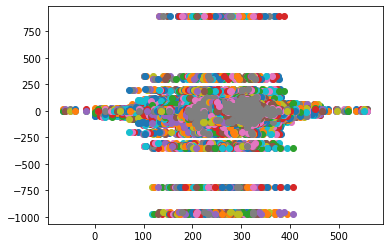

In [18]:
import matplotlib.pyplot as plt
for i in range(136):
    plt.scatter(df.iloc[:,i].values, df.iloc[:,-3].values )
    plt.scatter(df.iloc[:,i].values, df.iloc[:,-2].values )
    plt.scatter(df.iloc[:,i].values, df.iloc[:,-1].values )

In [19]:
from sklearn.preprocessing import StandardScaler
dat = StandardScaler()
datt = dat.fit_transform(df.iloc[:,:-3])

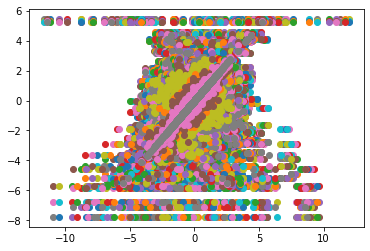

In [20]:
import matplotlib.pyplot as plt
for i in range(136):
    plt.scatter(datt[:,i], datt[:,-3] )
    plt.scatter(datt[:,i], datt[:,-2] )
    plt.scatter(datt[:,i], datt[:,-1] )

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-3].values,df.iloc[:,-3:].values , test_size=0.30, random_state=500)

In [22]:
'''y=df[['yaw','pitch','roll']]
X=df.drop(columns=['yaw','pitch','roll'],axis=1)'''

"y=df[['yaw','pitch','roll']]\nX=df.drop(columns=['yaw','pitch','roll'],axis=1)"

In [23]:
'''from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datt,df.iloc[:,-3:].values, test_size=0.30, random_state=500)'''

'from sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(datt,df.iloc[:,-3:].values, test_size=0.30, random_state=500)'

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfr = RandomForestRegressor()
svr = SVR(kernel='rbf', C=1)
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate = 0.1)
model = MultiOutputRegressor(estimator=rfr,n_jobs = -1)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Training score:", score)

Training score: 0.9159580681213525


In [25]:
ypred = model.predict(X_test)
ypred.shape

(600, 3)

In [26]:
from sklearn.metrics import r2_score
print("y1 score:%.4f" % r2_score(y_test[:,0], ypred[:,0]))
print("y2 score:%.4f" % r2_score(y_test[:,1], ypred[:,1]))
print("y3 score:%.4f" % r2_score(y_test[:,2], ypred[:,2]))

y1 score:0.9957
y2 score:0.6486
y3 score:0.8124


In [27]:
r2_score(y_test, ypred)

0.8188829234956653

In [28]:
model.score(X_test , y_test)

0.8188829234956653

### detector

In [29]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img



In [30]:
def detect_face(img_path):
    face_detector = dlib.get_frontal_face_detector()
    img = cv2.imread(img_path)
    #print(img.shape)
    #print("-------------------")
    #gray = None
    #gray = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print(gray)
    #print(gray.shape)
    #print("-------------------")
    faces= face_detector(gray)
    #print(faces)
  

    return img, gray, faces
    

In [31]:
def draw_face(img, gray, faces):
    for (idx, face) in enumerate(faces):
            # Get x_min, y_min, x_max, y_max, conf
            x_min = face.left()
            y_min = face.top()
            x_max = face.right()-x_min
            y_max = face.bottom()-y_min
            # conf = det.confidence
            # print(det)
            landmark_detector=dlib.shape_predictor('/home/ayah/Desktop/Pose Detection/shape_predictor_68_face_landmarks.dat')

            landmarks = landmark_detector(gray, face)
            tdx,tdy=landmarks.part(30).x, landmarks.part(30).y
            bbox_height, bbox_width = img.shape[:2]
           
            cv2.destroyAllWindows()
            plt.figure(figsize=(20,8))
            # numbers are yaw, pitch, roll
            plt.imshow(draw_axis(img,-5.620685,-4.7939262 ,2.5846152,tdx,tdy)
            )
 

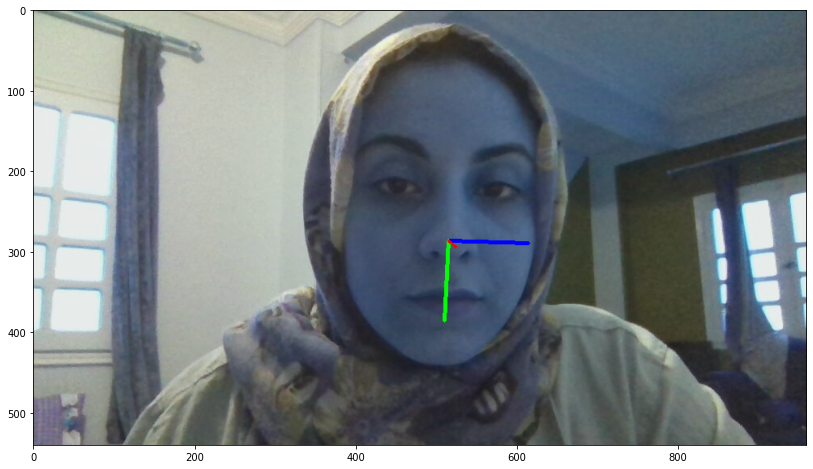

In [43]:
image='/home/ayah/Desktop/Pose Detection/Data/2022-06-06-163608.jpg'
img , gray, face = detect_face(image)
draw_face(img, gray, face)

In [44]:
!bzip2 -d  '/home/ayah/Desktop/Pose Detection/shape_predictor_68_face_landmarks.dat.bz2'

bzip2: Output file /home/ayah/Desktop/Pose Detection/shape_predictor_68_face_landmarks.dat already exists.


In [46]:
def landmark_detector(img, face):
    landmark_detector=dlib.shape_predictor('/home/ayah/Desktop/Pose Detection/shape_predictor_68_face_landmarks.dat')
    landmarks = np.zeros((68,2))
    img = cv2.imread(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    landmarks_= landmark_detector(gray, face)    
    
    for i in range(68):
        x = landmarks_.part(i).x
        if x > 360 : x-= 360
        landmarks[i,0] = x
        y = landmarks_.part(i).y
        if y > 360 : y-=360
        landmarks[i, 1] = y
        
    return landmarks, landmarks_

In [47]:
def draw_landmarks(image, landmarks, color=(0,0,0)):
        image = cv2.imread(image)
        #print(landmarks)
        for i in range(0, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            #cv2.circle(frame, (int(pt2d[0][j]),int(pt2d[1][j])), radius=0, color=(0, 0, 0), thickness=5)
            cv2.circle(image, (x, y), 4, color, -1)
        tdx,tdy=landmarks.part(30).x, landmarks.part(30).y
        plt.figure(figsize=(20,8))
        plt.imshow(draw_axis(image,-5.620685,-4.7939262 ,2.5846152,tdx,tdy)
        )

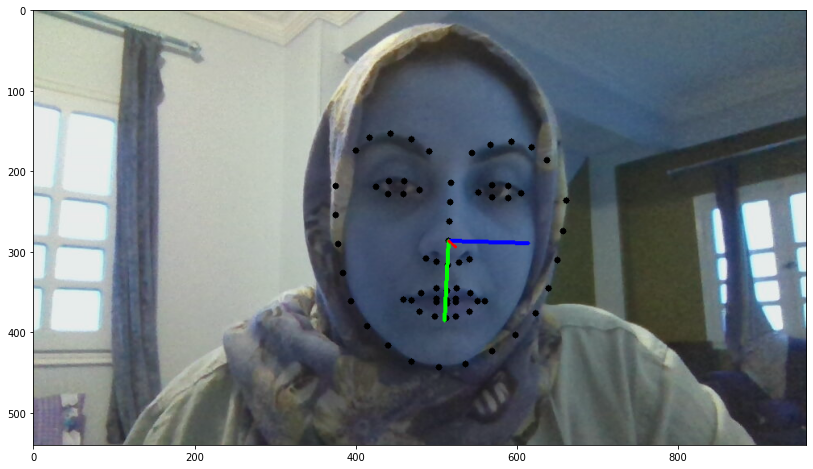

In [48]:
image='/home/ayah/Desktop/Pose Detection/Data/2022-06-06-163608.jpg'
faces = detect_face(image)[2]
for (idx, face) in enumerate(faces): face = face
landmarks, landmarks_ = landmark_detector(image,face) # x , y 68 points
draw_landmarks(image, landmarks_)

In [49]:
landmarks_x = landmarks[:,0]
landmarks_y = landmarks[:,1]

In [50]:
landmarks_final = np.array([landmarks_x, landmarks_y]).reshape(1,-1)

In [51]:
landmarks_final.shape

(1, 136)

In [52]:
ypred = model.predict(landmarks_final)

In [53]:
ypred

array([[  3.75637954, -11.8395517 ,  -6.64497971]])

In [61]:
# photo 1 (default): array([[  24.34167525, -100.74817926, -443.55666941]])
# photo 2 (pitch down) : 